- Random Forest y XGBoost

El objetivo es construir un modelo de machine learning para predecir la deserción de usuarios (churn). Para ello, se probarán dos modelos basados en árboles: Random Forest y XGBoost. El trabajo ayudó a tomar decisiones para prevenir la deserción y mejorar la retención de usuarios.

 Un falso negativo (predecir que un usuario no cancelará, pero sí lo hace) significa perder la oportunidad de retenerlo. Un falso positivo (predecir que un usuario cancelará, pero no lo hace) podría molestar a usuarios leales con acciones innecesarias. 

1. Importaciones y carga de datos

In [81]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Esto nos permite ver todas las columnas
pd.set_option('display.max_columns', None)

# Importar paquetes para el modelado de datos
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Función que ayuda a graficar la importancia de las características
from xgboost import plot_importance

# Módulo para guardar nuestros modelos una vez ajustados
import pickle

# Importar el conjunto de datos
df0 = pd.read_csv('waze_dataset.csv')

df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [82]:
# Copiar el dataframe df0 
df = df0.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


Crear una característica que representa el promedio de kilómetros conducidos por cada día de conducción.

In [83]:
# 1. Crear la característica `km_por_dia_de_conduccion`
df['km_por_dia_de_conduccion'] = df['driven_km_drives'] / df['driving_days']

# 2. Convertir valores infinitos a cero (resultado de la división por cero)
df.loc[df['km_por_dia_de_conduccion']==np.inf, 'km_por_dia_de_conduccion'] = 0

# 3. Confirmar que funcionó
df['km_por_dia_de_conduccion'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_por_dia_de_conduccion, dtype: float64

Crear una columna que representa el porcentaje de sesiones totales del usuario que ocurrieron en el último mes.

In [84]:
# 1. Crear la característica `porcentaje_sesiones_ultimo_mes`
df['porcentaje_sesiones_ultimo_mes'] = df['sessions'] / df['total_sessions']

df['porcentaje_sesiones_ultimo_mes'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: porcentaje_sesiones_ultimo_mes, dtype: float64

Crea una característica binaria (1 o 0) para identificar a los usuarios que parecen ser conductores profesionales (>=60 viajes y >=15 días de conducción en el último mes).

In [85]:
# Crear la característica `conductor_profesional`
df['conductor_profesional'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

Crear una columna con el número promedio de sesiones por día desde que el usuario se registró.

In [86]:
df['total_sesiones_por_dia'] = df['total_sessions'] / df['n_days_after_onboarding']

df['total_sesiones_por_dia'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sesiones_por_dia, dtype: float64

Crear una columna para la velocidad promedio en km/h durante el último mes.

In [87]:
df['km_por_hora'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_por_hora'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_por_hora, dtype: float64

Crear una columna para el promedio de kilómetros por viaje en el último mes.

In [88]:
df['km_por_viaje'] = df['driven_km_drives'] / df['drives']

# Convertir valores infinitos a cero
df.loc[df['km_por_viaje']==np.inf, 'km_por_viaje'] = 0

df['km_por_viaje'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_por_viaje, dtype: float64

Crear una columna que representa el porcentaje de sesiones totales que se usaron para navegar a un lugar favorito.

In [89]:
# Crear la característica `porcentaje_viajes_a_favoritos`
df['porcentaje_viajes_a_favoritos'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

df['porcentaje_viajes_a_favoritos'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: porcentaje_viajes_a_favoritos, dtype: float64

Se eliminan las filas con valores faltantes en la columna label ya que representan menos del 5% de los datos.

In [90]:
df = df.dropna(subset=['label'])

Los modelos basados en árboles son resistentes a los valores atípicos, por lo que no se realiza ninguna imputación.

Para usar la variable device, se convierte a formato numérico: Android -> 0, iPhone -> 1.

In [91]:
# Crear la nueva variable binaria "dispositivo2"

df['dispositivo2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'dispositivo2']].tail()

,device,dispositivo2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


La variable objetivo label también se codifica: retained -> 0, churned -> 1.

In [92]:
# Crear la columna binaria "etiqueta2"

df['etiqueta2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'etiqueta2']].tail()

,label,etiqueta2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


Se elimina la columna ID ya que no es relevante para el modelo.

In [93]:
df = df.drop(['ID'], axis=1)

El conjunto de datos está desbalanceado (aproximadamente 18% de usuarios cancelaron). Dado que el riesgo de un falso positivo es bajo, se elegirá el modelo con la mejor puntuación de recall, ya que es más importante identificar correctamente a los usuarios que van a cancelar.

In [94]:
# Obtener el balance de clases de la columna "label"

df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

El proceso de modelado incluye dividir los datos en conjuntos de entrenamiento, validación y prueba (60/20/20), ajustar los modelos y sus hiperparámetros, y seleccionar un modelo sobresaliente para la evaluación final.

Dividir los datos

Se separan las características (X) de la variable objetivo (y) y se dividen los datos.

In [95]:
# 1. Aislar las variables X
X = df.drop(columns=['label', 'etiqueta2', 'device'])

# 2. Aislar la variable y
y = df['etiqueta2']

# 3. Dividir en conjuntos de entrenamiento interino y prueba (80/20)
X_entrenamiento_temp, X_prueba, y_entrenamiento_temp, y_prueba = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Dividir el conjunto interino en entrenamiento y validación (75/25)
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_entrenamiento_temp, y_entrenamiento_temp, stratify=y_entrenamiento_temp,
                                                  test_size=0.25, random_state=42)

Verificar el tamaño de cada conjunto de datos.

In [96]:
for x in [X_entrenamiento, X_validacion, X_prueba]:
    print(len(x))

8579
2860
2860


Ahora, se construirán y optimizarán los modelos de clasificación.

- Random Forest 

Se comienza ajustando un modelo de Random Forest usando GridSearchCV para encontrar los mejores hiperparámetros.

In [97]:
# 1. Instanciar el clasificador de random forest
rf = RandomForestClassifier(random_state=42)

# 2. Crear un diccionario de hiperparámetros para ajustar
# Nota: para ahorrar tiempo, se usan valores únicos, pero se debería probar un rango de valores.
parametros_cv = {'max_depth': [None],
                 'max_features': [1.0],
                 'max_samples': [1.0],
                 'min_samples_leaf': [2],
                 'min_samples_split': [2],
                 'n_estimators': [300],
                }

# 3. Definir una lista de métricas de puntuación
metricas = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instanciar el objeto GridSearchCV
# Se optimiza para 'recall' porque es la métrica más importante para este caso de uso.
rf_cv = GridSearchCV(rf, parametros_cv, scoring=metricas, cv=4, refit='recall')

# Ajustar el modelo a los datos de entrenamiento
rf_cv.fit(X_entrenamiento, y_entrenamiento)

# Examinar la mejor puntuación promedio de "recall"
print(f"Mejor puntuación (Recall): {rf_cv.best_score_}")

# Examinar la mejor combinación de hiperparámetros
print(f"Mejores parámetros: {rf_cv.best_params_}")

Mejor puntuación (Recall): 0.12678201409034398
Mejores parámetros: {'max_depth': None, 'max_features': 1.0, 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


Para organizar los resultados, se crea una función que extrae las métricas clave de los modelos ajustados.

In [98]:
def generar_resultados(nombre_modelo:str, objeto_modelo, metrica:str):
    # Diccionario para mapear la métrica de entrada con su nombre en GridSearchCV
    diccionario_metricas = {'precision': 'mean_test_precision',
                          'recall': 'mean_test_recall',
                          'f1': 'mean_test_f1',
                          'accuracy': 'mean_test_accuracy',
                         }

    # Obtener los resultados de la validación cruzada
    resultados_cv = pd.DataFrame(objeto_modelo.cv_results_)

    # Aislar la fila con la puntuación máxima de la métrica
    mejores_resultados = resultados_cv.iloc[resultados_cv[diccionario_metricas[metrica]].idxmax(), :]

    # Extraer las puntuaciones
    f1 = mejores_resultados.mean_test_f1
    recall = mejores_resultados.mean_test_recall
    precision = mejores_resultados.mean_test_precision
    accuracy = mejores_resultados.mean_test_accuracy

    # Crear tabla de resultados
    tabla = pd.DataFrame({'modelo': [nombre_modelo],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                         })
    return tabla

# Generar la tabla de resultados para el modelo Random Forest
resultados = generar_resultados('RF cv', rf_cv, 'recall')
resultados

,modelo,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.81851


- Aunque la precisión es decente, las otras métricas no son muy altas. Sin embargo, el recall es un 33% mejor que el de un modelo de regresión logística previo, con una precisión similar.

- XGBoost

In [99]:
# 1. Instanciar el clasificador XGBoost
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Crear un diccionario de hiperparámetros para ajustar
parametros_cv_xgb = {'max_depth': [6, 12],
                     'min_child_weight': [3, 5],
                     'learning_rate': [0.01, 0.1],
                     'n_estimators': [300]
                    }

# 3. Definir una lista de métricas
metricas = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instanciar el objeto GridSearchCV, optimizando de nuevo para 'recall'
xgb_cv = GridSearchCV(xgb, parametros_cv_xgb, scoring=metricas, cv=4, refit='recall')

# Ajustar el modelo
xgb_cv.fit(X_entrenamiento, y_entrenamiento)

# Examinar la mejor puntuación de 'recall'
print(f"Mejor Puntuación (Recall): {xgb_cv.best_score_}")

# Examinar los mejores parámetros
print(f"Mejores Parámetros: {xgb_cv.best_params_}")

# Generar y añadir los resultados de XGBoost a la tabla
resultados_xgb_cv = generar_resultados('XGB cv', xgb_cv, 'recall')
resultados = pd.concat([resultados, resultados_xgb_cv], axis=0)
resultados

Mejor Puntuación (Recall): 0.17936351706036746
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 300}


,modelo,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.424500,0.179364,0.251974,0.811167


El modelo XGBoost superó al de Random Forest. Su recall es casi el doble que el del modelo logístico y un 50% mejor que el de Random Forest, manteniendo una precisión y exactitud similares.

Se usan los mejores modelos de Random Forest y XGBoost para predecir sobre los datos de validación. El que tenga mejor rendimiento será el modelo campeón.

In [100]:
# Función para generar una tabla con las puntuaciones de prueba/validación
def obtener_puntuaciones_prueba(nombre_modelo:str, predicciones, datos_y):
    accuracy = accuracy_score(datos_y, predicciones)
    precision = precision_score(datos_y, predicciones)
    recall = recall_score(datos_y, predicciones)
    f1 = f1_score(datos_y, predicciones)

    tabla = pd.DataFrame({'modelo': [nombre_modelo],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })
    return tabla

# Predecir y obtener puntuaciones para Random Forest en el conjunto de validación
predicciones_rf_val = rf_cv.best_estimator_.predict(X_validacion)
puntuaciones_rf_val = obtener_puntuaciones_prueba('RF val', predicciones_rf_val, y_validacion)
resultados = pd.concat([resultados, puntuaciones_rf_val], axis=0)

# Predecir y obtener puntuaciones para XGBoost en el conjunto de validación
predicciones_xgb_val = xgb_cv.best_estimator_.predict(X_validacion)
puntuaciones_xgb_val = obtener_puntuaciones_prueba('XGB val', predicciones_xgb_val, y_validacion)
resultados = pd.concat([resultados, puntuaciones_xgb_val], axis=0)

resultados

,modelo,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.424500,0.179364,0.251974,0.811167
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.395556,0.175542,0.243169,0.806294


- Las puntuaciones en el conjunto de validación disminuyeron ligeramente para ambos modelos, lo que indica que no hay un sobreajuste significativo. XGBoost sigue siendo el mejor modelo.

Se evalúa el modelo XGBoost en el conjunto de prueba para estimar su rendimiento en datos futuros.

In [101]:
# Usar el modelo XGBoost para predecir en los datos de prueba
predicciones_xgb_prueba = xgb_cv.best_estimator_.predict(X_prueba)

# Obtener las puntuaciones finales
puntuaciones_xgb_prueba = obtener_puntuaciones_prueba('XGB prueba', predicciones_xgb_prueba, y_prueba)

# Añadir a la tabla de resultados
resultados = pd.concat([resultados, puntuaciones_xgb_prueba], axis=0)
resultados

,modelo,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.424500,0.179364,0.251974,0.811167
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.395556,0.175542,0.243169,0.806294
0,XGB prueba,0.416327,0.201183,0.271277,0.808392


El rendimiento se mantuvo estable, confirmando la buena calidad del modelo.

Se visualiza la matriz de confusión para entender los tipos de errores del modelo.

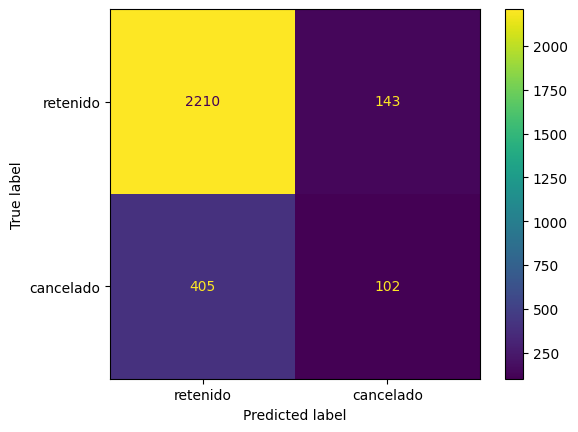

In [102]:
# Generar valores para la matriz de confusión
matriz_confusion = confusion_matrix(y_prueba, predicciones_xgb_prueba, labels=xgb_cv.classes_)

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion,
                             display_labels=['retenido', 'cancelado'])
disp.plot();

La matriz muestra que el modelo predijo más de tres veces más falsos negativos que falsos positivos, y solo identificó correctamente al 18.1% de los usuarios que realmente cancelaron.

Se inspeccionan las características más influyentes para el modelo XGBoost.



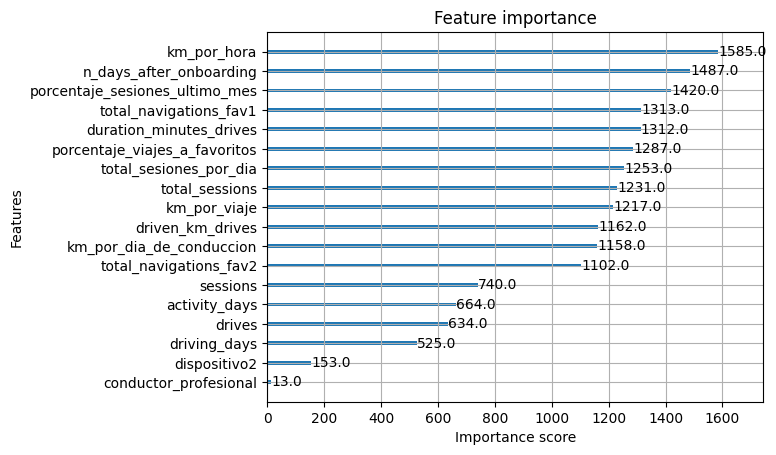

In [103]:
plot_importance(xgb_cv.best_estimator_);

El modelo XGBoost utilizó una variedad de características. Se puede notar que 6 de las 10 características más importantes fueron las que se crearon mediante ingeniería de características, lo que demuestra el valor de este proceso para mejorar el rendimiento del modelo.

- Conclusión

¿Recomendarías usar este modelo? depende del objetivo. No para decisiones críticas de negocio, debido a su bajo "recall". Sí como una herramienta para guiar futuras exploraciones y entender mejor los factores de churn.

¿Cuál es el beneficio de usar regresión logística sobre modelos de árboles? la regresión logística es más fácil de interpretar. Sus coeficientes muestran no solo qué características son importantes, sino también si su relación con el churn es positiva o negativa.

¿Cuál es el beneficio de usar modelos de árboles (Random Forest, XGBoost) sobre regresión logística? generalmente, tienen un mayor poder predictivo. Además, requieren menos pre-procesamiento de datos y son más flexibles.

¿Qué se podría hacer para mejorar el modelo?

- Crear nuevas características (ingeniería de características).

- Probar diferentes combinaciones de variables para reducir el ruido.

- Obtener datos adicionales, como información a nivel de viaje (tiempos, ubicaciones) o interacciones más detalladas con la app (reportes de alertas, etc.).

- Extra: Umbral de decisión óptimo

El umbral de decisión utilizado por defecto para la mayoría de los algoritmos de clasificación es 0.5. Esto significa que si el modelo predice que un usuario tiene una probabilidad del 50% o más de desertar, se le asigna una predicción de 1 (churn).

Sin embargo, en conjuntos de datos desbalanceados, este umbral puede no ser el ideal. La curva de precisión-recall ayuda a visualizar el equilibrio entre estas dos métricas.

Aquí está la curva para el modelo ganador (XGBoost) en los datos de prueba.

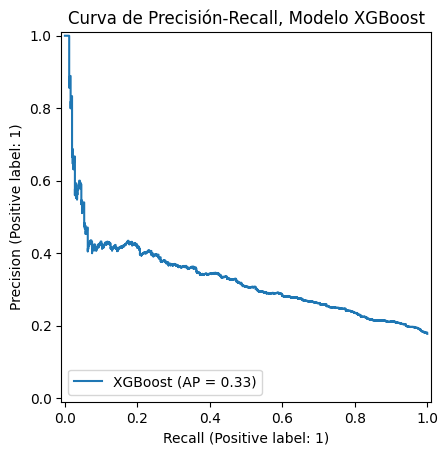

In [104]:
# Graficar la curva de precisión-recall
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_prueba, y_prueba, name='XGBoost'
    )
plt.title('Curva de Precisión-Recall, Modelo XGBoost');

Como se puede ver, a medida que el "recall" aumenta, la precision disminuye. Pero, ¿qué pasa si determinamos que los falsos positivos no son un gran problema? En este proyecto de Waze, un falso positivo solo significa que un usuario que no iba a cancelar recibe una notificación. El riesgo es muy bajo.

Entonces, ¿qué pasaría si en lugar de usar el umbral de 0.5, usamos uno más bajo?

El método predict_proba() devuelve un array con las probabilidades de que cada usuario pertenezca a la clase negativa (columna 0) y a la clase positiva (columna 1).



In [105]:
# Obtener las probabilidades predichas en los datos de prueba
probabilidades_predichas = xgb_cv.best_estimator_.predict_proba(X_prueba)
probabilidades_predichas

array([[0.97292364, 0.02707635],
       [0.43276215, 0.56723785],
       [0.9978458 , 0.00215418],
       ...,
       [0.80911976, 0.19088024],
       [0.96015054, 0.03984944],
       [0.73966384, 0.26033613]], shape=(2860, 2), dtype=float32)

Podemos generar nuevas predicciones usando estas probabilidades con un umbral diferente. Por ejemplo, el siguiente código asigna una predicción de 1 a cualquier usuario con una probabilidad de deserción >= 0.4.

In [106]:
# Crear una lista solo con los valores de la segunda columna (probabilidad de churn)
probabilidades = [x[1] for x in probabilidades_predichas]

# Crear un array de nuevas predicciones con un umbral de 0.4
nuevas_predicciones = np.array([1 if x >= 0.4 else 0 for x in probabilidades])

# Obtener las métricas de evaluación para el nuevo umbral
obtener_puntuaciones_prueba('XGB, umbral = 0.4', nuevas_predicciones, y_prueba)

,modelo,precision,recall,F1,accuracy
0,"XGB, umbral = 0.4",0.385965,0.260355,0.310954,0.795455


Al comparar estos resultados con los anteriores, se observa que el Recall y el F1-score aumentaron significativamente, mientras que la precisión y la exactitud disminuyeron marginalmente.

Supongamos que el objetivo es tener un recall de 0.5 y estamos dispuestos a aceptar la precision de ~30% que lo acompaña. En otras palabras, estaríamos satisfechos si el modelo identifica a la mitad de las personas que realmente cancelarán.

La siguiente función nos ayuda a encontrar el umbral que produce este resultado.

In [107]:
def encontrar_umbral(datos_y, probabilidades, recall_deseado):
    # Aislar la segunda columna de las probabilidades (probabilidad de churn)
    probs = [x[1] for x in probabilidades]
    # Probar 1,000 umbrales diferentes entre 0 y 1
    umbrales = np.arange(0, 1, 0.001)

    puntuaciones = []
    for umbral in umbrales:
        # Crear nuevas predicciones basadas en el umbral actual
        predicciones = np.array([1 if x >= umbral else 0 for x in probs])
        # Calcular el recall para ese umbral
        recall = recall_score(datos_y, predicciones)
        # Añadir el umbral y su recall a la lista
        puntuaciones.append((umbral, recall))

    distancias = []
    for indice, puntuacion in enumerate(puntuaciones):
        # Calcular qué tan cerca está cada recall del recall deseado
        distancia = abs(puntuacion[1] - recall_deseado)
        distancias.append((indice, distancia))

    # Ordenar las distancias de menor a mayor
    distancias_ordenadas = sorted(distancias, key=lambda x: x[1], reverse=False)
    # Identificar la tupla con la distancia más corta
    mejor = distancias_ordenadas[0]
    # Aislar el índice del mejor umbral
    mejor_indice = mejor[0]
    # Obtener el umbral y el recall correspondientes
    umbral, recall = puntuaciones[mejor_indice]

    return umbral, recall

# Obtener las probabilidades predichas del modelo campeón
probabilidades = xgb_cv.best_estimator_.predict_proba(X_prueba)

# Llamar a la función para encontrar el umbral que da un recall cercano a 0.5
encontrar_umbral(y_prueba, probabilidades, 0.5)

(np.float64(0.145), 0.5009861932938856)

La función indica que un umbral de 0.145 resultará en un recall de 0.500.

Para verificarlo, repetimos los pasos anteriores para obtener todas las métricas de evaluación con este nuevo umbral.

In [108]:
# Crear un array de nuevas predicciones con un umbral de 0.194
probabilidades = [x[1] for x in probabilidades]
nuevas_predicciones = np.array([1 if x >= 0.194 else 0 for x in probabilidades])

# Obtener las métricas de evaluación para el umbral de 0.194
obtener_puntuaciones_prueba('XGB, umbral = 0.194', nuevas_predicciones, y_prueba)

,modelo,precision,recall,F1,accuracy
0,"XGB, umbral = 0.194",0.334315,0.447732,0.382799,0.744056


 Como se esperaba según la curva de precisión-recall, un recall de ~0.5 se corresponde con una precision de ~0.3.